# Q Learning

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
import imageio
from collections import defaultdict

In [2]:
class RoverGridEnv(gym.Env):
    metadata={'render.modes': ['human']}
    def __init__(self,max_ts=30):
        super(RoverGridEnv,self).__init__()
        self.max_ts=max_ts
        self.grid_size=(15,15)
        self.action_space=gym.spaces.MultiDiscrete([5,5])
        self.observation_space=gym.spaces.MultiDiscrete([15,15,15,15,15,15])
        self.actions=[(0,-1),(0,1),(-1,0),(1,0),(0,0)]
        self.targets=np.array([[5,10],[9,13]]) 
        self.rover_positions=np.array([[6,4],[10,4]])
        self.operation_desks=np.array([[6,3],[10,3]])
        self.rooms=np.array([[4,7],[4,10],[4,13],[8,7],[8,10],[8,13],[12,7],[12,10],[12,13]])
        self.human_position=np.array([8,9])
        self.rover_done=[False,False] 
        self.reset()

    def reset(self):
        self.rover_positions=np.array([[6,4],[10,4]])
        self.human_position=np.array([7,8])
        self.rover_done=[False,False]
        self.current_step=0
        return self._get_obs()

    def _get_obs(self):
        return tuple(self.rover_positions.flatten().tolist()+self.human_position.tolist())

    def step(self,actions):
        rewards=np.zeros(2)
        done=[False,False]
        info={'message': ''}
        for i,action in enumerate(actions):
            if self.rover_done[i]:
                done[i]=True
                continue
            prev_distance=np.linalg.norm(self.targets[i]-self.rover_positions[i])
            if self._is_human_adjacent(self.rover_positions[i]):
                rewards[i] -= 5
            else:
                delta=np.array(self.actions[action])
                new_position=self.rover_positions[i]+delta
                if self._out_of_bounds(new_position):
                    rewards[i] -= 15
                    continue
                if self._collision(new_position,i):
                    rewards[i] -= 15
                    continue
                self.rover_positions[i]=new_position
                new_distance=np.linalg.norm(self.targets[i]-new_position)
                if new_distance < prev_distance:
                    rewards[i]+=30
                else:
                    rewards[i] -= 20
                if np.array_equal(new_position,self.targets[i]):
                    rewards[i]+=100
                    self.rover_done[i]=True
                    done[i]=True
        self._move_human()
        self.current_step+=1
        all_done=all(done) or self.current_step >= self.max_ts
        if all_done and not all(done):
            info['message']='Maximum number of timestamps reached'
        return self._get_obs(),rewards,all_done,info

    def _is_human_adjacent(self,position):
        for delta in [(1,1),(1,-1),(-1,1),(-1,-1)]:
            adjacent_position=position+np.array(delta)
            if np.array_equal(adjacent_position,self.human_position):
                return True
        return False

    def _out_of_bounds(self,position):
        return not (0 <= position[0] < self.grid_size[0] and 0 <= position[1] < self.grid_size[1])
    
    def _collision(self,new_position,rover_index):
        if any(np.array_equal(new_position,pos) for pos in np.delete(self.rover_positions,rover_index,axis=0)):
            return True  # Collision with the other rover
        if any(np.array_equal(new_position,pos) for pos in self.rooms):
            return True  # Collision with a room
        if any(np.array_equal(new_position,pos) for pos in self.operation_desks):
            return True  # Collision with an operation desk
        if np.array_equal(new_position,self.human_position):
            return True  # Collision with the human
        return False
    
    def _move_human(self):
        valid_moves=[move for move in self.actions if not self._out_of_bounds(self.human_position+np.array(move))]
        self.human_position+=np.array(valid_moves[np.random.choice(len(valid_moves))])
    
    def render(self,mode='human',save_path=None):
        fig,ax=plt.subplots(figsize=(7,7))
        ax.set_xlim(0,self.grid_size[0])
        ax.set_ylim(0,self.grid_size[1])
        ax.set_xticks(np.arange(0,15,1))
        ax.set_yticks(np.arange(0,15,1))
        ax.grid(which='both')

        # draw elements
        for pos in self.rover_positions:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='blue'))
        for pos in self.operation_desks:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='darkgreen'))
        for pos in self.rooms:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='black'))
        ax.add_patch(Rectangle((self.human_position[0]-0.5,self.human_position[1]-0.5),1,1,color='purple'))
        for pos in self.targets:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='yellow',alpha=0.5))

        if save_path is not None:
            plt.savefig(save_path)
            plt.close()
    
    def close(self):
        plt.close()

Initial Setup


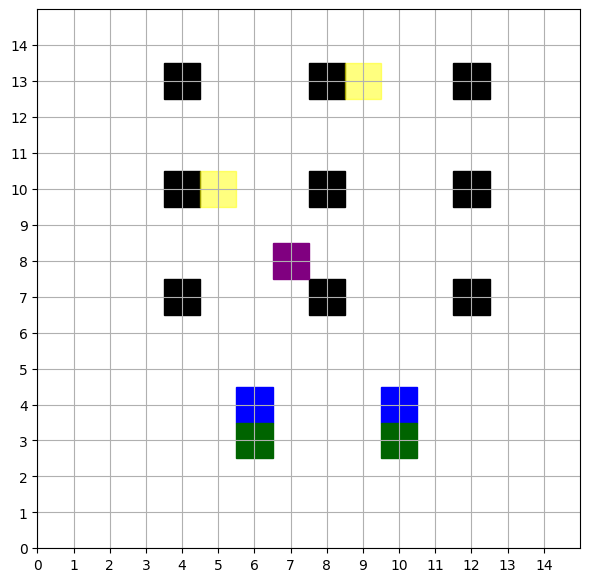

In [3]:
env=RoverGridEnv()
print("Initial Setup")
observation=env.reset()
env.render()

# Q learning

In [4]:
class rover_QLearning:
    def __init__(self,
                 actions,
                 alpha=1e-4,
                 gamma=0.9,
                 eps=0.5,
                 eps_decay=0.995,
                 eps_min=0.01):
        self.actions=actions
        self.alpha=alpha 
        self.gamma=gamma 
        self.eps=eps
        self.eps_decay=eps_decay 
        self.eps_min=eps_min  
        self.q_table=defaultdict(lambda: np.zeros(len(self.actions))) 

    def choose_action(self,stt):
        if np.random.random() < self.eps:
            return np.random.choice(len(self.actions))
        else:
            return np.argmax(self.q_table[stt])  

    def update(self,
               stt,
               action,
               reward,
               nxt_stt):
        best_next_action=np.argmax(self.q_table[nxt_stt])
        td_target=reward+self.gamma*self.q_table[nxt_stt][best_next_action]
        td_error=td_target-self.q_table[stt][action]
        self.q_table[stt][action]+=self.alpha*td_error

    def decay_epsilon(self):
        self.eps=max(self.eps_min,
                       self.eps*self.eps_decay)

In [7]:
env=RoverGridEnv()
agents=[
    rover_QLearning(actions=[0,1,2,3,4]),
    rover_QLearning(actions=[0,1,2,3,4])
]
num_epis=2000
episode_rwds_q_learning=[]
epsilon_values_agent1 = []
epsilon_values_agent2 = []
#Training
for episode in range(num_epis):
    stt=env.reset()
    cumulative_rewards=[0,0]
    for step in range(env.max_ts):
        actions=[agent.choose_action(stt) for agent in agents]
        nxt_stt,rewards,done,info=env.step(actions)
        for i,agent in enumerate(agents):
            agent.update(stt,actions[i],rewards[i],nxt_stt)
            cumulative_rewards[i]+=rewards[i]
        stt=nxt_stt
        if done:
            break
    episode_rwds_q_learning.append(np.sum(cumulative_rewards)) 
    for i, agent in enumerate(agents):
        agent.decay_epsilon()
        if i == 0:
            epsilon_values_agent1.append(agent.eps) 
        else:
            epsilon_values_agent2.append(agent.eps)  
    print(f"Episode {episode+1}/{num_epis} completed with rewards: {np.sum(cumulative_rewards)}")


Episode 1/2000 completed with rewards: -610.0
Episode 2/2000 completed with rewards: -360.0
Episode 3/2000 completed with rewards: -410.0
Episode 4/2000 completed with rewards: -415.0
Episode 5/2000 completed with rewards: -595.0
Episode 6/2000 completed with rewards: -455.0
Episode 7/2000 completed with rewards: -435.0
Episode 8/2000 completed with rewards: -340.0
Episode 9/2000 completed with rewards: -735.0
Episode 10/2000 completed with rewards: -665.0
Episode 11/2000 completed with rewards: -565.0
Episode 12/2000 completed with rewards: -535.0
Episode 13/2000 completed with rewards: -595.0
Episode 14/2000 completed with rewards: -235.0
Episode 15/2000 completed with rewards: -435.0
Episode 16/2000 completed with rewards: -315.0
Episode 17/2000 completed with rewards: -315.0
Episode 18/2000 completed with rewards: -540.0
Episode 19/2000 completed with rewards: -535.0
Episode 20/2000 completed with rewards: -440.0
Episode 21/2000 completed with rewards: -400.0
Episode 22/2000 comple

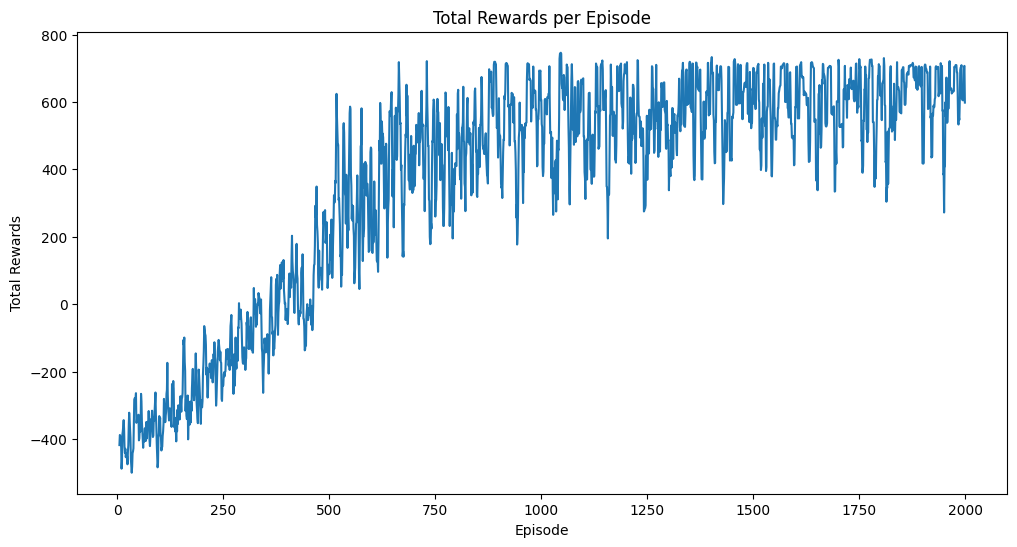

In [8]:
plt.figure(figsize=(12,6))
plt.plot(range(len(episode_rwds_q_learning)),episode_rwds_q_learning)
plt.title("Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Rewards")
plt.show()

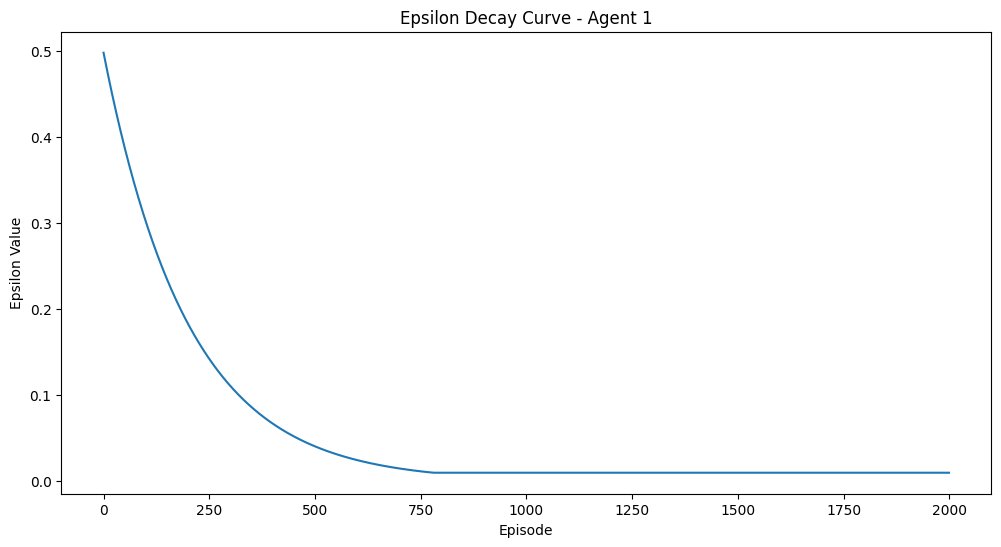

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(epsilon_values_agent1)), epsilon_values_agent1)
plt.title("Epsilon Decay Curve - Agent 1")
plt.xlabel("Episode")
plt.ylabel("Epsilon Value")
plt.show()

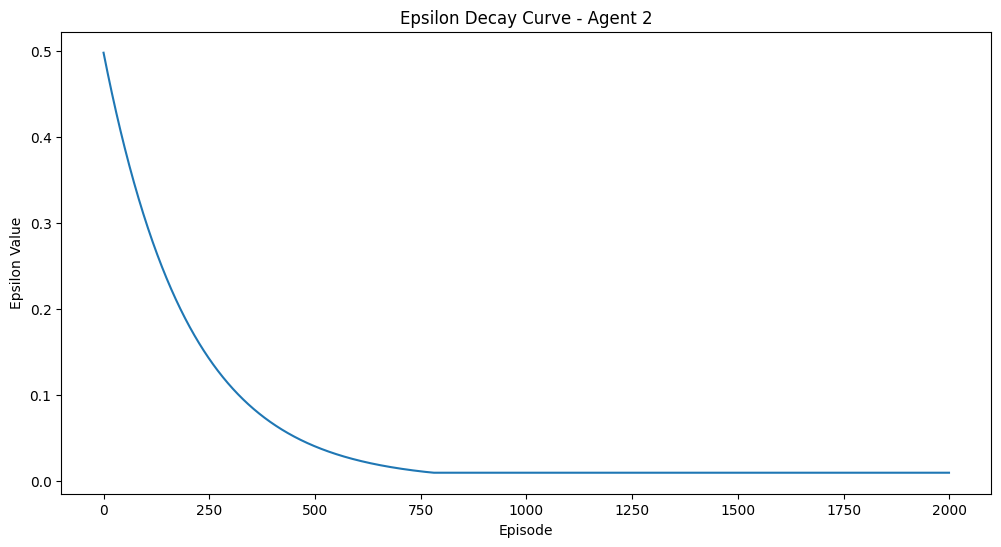

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(epsilon_values_agent2)), epsilon_values_agent2)
plt.title("Epsilon Decay Curve - Agent 2")
plt.xlabel("Episode")
plt.ylabel("Epsilon Value")
plt.show()

C:\Users\91740\AppData\Local\Temp\ipykernel_8004\1289474676.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(path) for path in frames_paths]


Episode 1 evaluated, GIF saved to q_learning_eval_gifs\episode_1.gif.
Episode 2 evaluated, GIF saved to q_learning_eval_gifs\episode_2.gif.
Episode 3 evaluated, GIF saved to q_learning_eval_gifs\episode_3.gif.
Episode 4 evaluated, GIF saved to q_learning_eval_gifs\episode_4.gif.
Episode 5 evaluated, GIF saved to q_learning_eval_gifs\episode_5.gif.
Episode 6 evaluated, GIF saved to q_learning_eval_gifs\episode_6.gif.
Episode 7 evaluated, GIF saved to q_learning_eval_gifs\episode_7.gif.
Episode 8 evaluated, GIF saved to q_learning_eval_gifs\episode_8.gif.
Episode 9 evaluated, GIF saved to q_learning_eval_gifs\episode_9.gif.
Episode 10 evaluated, GIF saved to q_learning_eval_gifs\episode_10.gif.


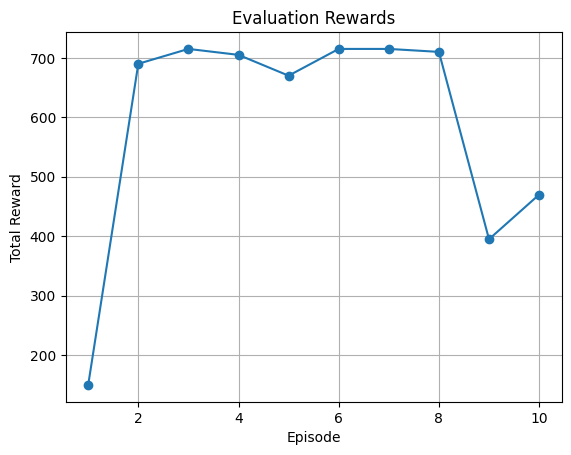

In [14]:
def evaluate_q_learning_agent(env,agents,num_epis=10,output_dir='q_learning_eval_gifs'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    eval_rwds_q_learning=[]
    for episode in range(num_epis):
        stt=env.reset()
        cumulative_rewards=[0,0]
        frames_paths=[]
        done=False
        timestep=0
        while not done:
            actions=[agent.choose_action(stt) for agent in agents]
            nxt_stt,rewards,done,_=env.step(actions)
            cumulative_rewards[0]+=rewards[0]
            cumulative_rewards[1]+=rewards[1]
            stt=nxt_stt
            frame_path=os.path.join(output_dir,f"episode_{episode+1}_frame_{timestep}.png")
            env.render(save_path=frame_path)
            frames_paths.append(frame_path)
            timestep+=1
        eval_rwds_q_learning.append(np.sum(cumulative_rewards))
        frames=[imageio.imread(path) for path in frames_paths]
        gif_path=os.path.join(output_dir,f"episode_{episode+1}.gif")
        imageio.mimsave(gif_path,frames,fps=10)
        for path in frames_paths:
            os.remove(path)
        print(f"Episode {episode+1} evaluated, GIF saved to {gif_path}.")

    plt.plot(range(1,num_epis+1),eval_rwds_q_learning,marker='o')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Evaluation Rewards')
    plt.grid(True)
    plt.show()
evaluate_q_learning_agent(env,agents,num_epis=10)